In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = r"D:\UWE CLASS\CSCT master\Master_project\Data\region_year_co2e.csv"
co2e = pd.read_csv(DATA_PATH)

OUT_DIR = r"D:\UWE CLASS\CSCT master\Master_project\Outputs\Forecasting"
os.makedirs(OUT_DIR, exist_ok=True)

co2e.head()


,region_name,year,co2e_tonnes_total
0,East Midlands,2015,9.237719e+06
1,East Midlands,2016,9.515900e+06
2,East Midlands,2017,9.671759e+06
3,East Midlands,2018,9.750602e+06
4,East Midlands,2019,9.921433e+06


In [2]:
print(co2e["year"].min(), co2e["year"].max(), co2e.shape)


2015 2024 (110, 3)


In [5]:
uk = co2e.groupby("year", as_index=False)["co2e_tonnes_total"].sum()
uk = uk.sort_values("year").reset_index(drop=True)
uk


,year,co2e_tonnes_total
0,2015,1.037690e+08
1,2016,1.060252e+08
2,2017,1.074507e+08
3,2018,1.079359e+08
4,2019,1.091377e+08
5,2020,8.814307e+07
6,2021,9.808780e+07
7,2022,1.052414e+08
8,2023,1.067908e+08
9,2024,1.080126e+08


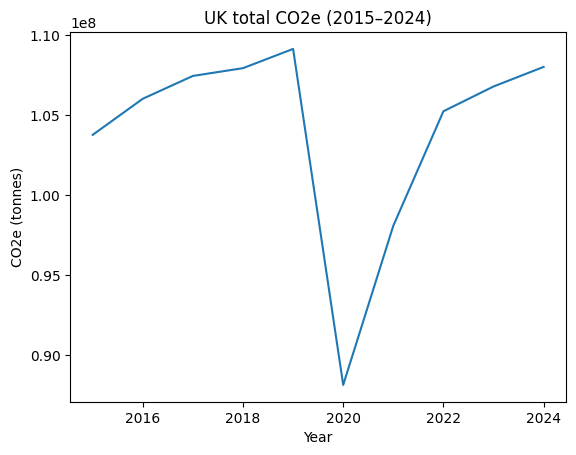

In [6]:
plt.figure()
plt.plot(uk["year"], uk["co2e_tonnes_total"])
plt.xlabel("Year")
plt.ylabel("CO2e (tonnes)")
plt.title("UK total CO2e (2015–2024)")
plt.show()


In [7]:
latest = co2e["year"].max()
top5_regions = (co2e[co2e["year"]==latest]
                .sort_values("co2e_tonnes_total", ascending=False)
                .head(5)["region_name"].tolist())
top5_regions


['South East', 'East of England', 'North West', 'South West', 'West Midlands']

In [8]:
def train_test_split_ts(df, y_col="co2e_tonnes_total", train_end=2022):
    train = df[df["year"] <= train_end].copy()
    test  = df[df["year"] >  train_end].copy()
    return train, test

def mae(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def fit_predict_naive(train, test, y_col="co2e_tonnes_total"):
    last_value = train[y_col].iloc[-1]
    return np.full(len(test), last_value)

def fit_predict_linear(train, test, y_col="co2e_tonnes_total"):
    X_train = train[["year"]].values
    y_train = train[y_col].values
    X_test  = test[["year"]].values

    model = LinearRegression()
    model.fit(X_train, y_train)
    return model.predict(X_test)

def fit_predict_holt(train, test, y_col="co2e_tonnes_total"):
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    y_train = train[y_col].values
    model = ExponentialSmoothing(y_train, trend="add", seasonal=None)
    fit = model.fit(optimized=True)
    return fit.forecast(len(test))


In [10]:
train_uk, test_uk = train_test_split_ts(uk, train_end=2022)

pred_naive = fit_predict_naive(train_uk, test_uk)
pred_lin   = fit_predict_linear(train_uk, test_uk)

results = []
results.append(["UK", "Naive", mae(test_uk["co2e_tonnes_total"], pred_naive),
                rmse(test_uk["co2e_tonnes_total"], pred_naive),
                mape(test_uk["co2e_tonnes_total"], pred_naive)])

results.append(["UK", "LinearTrend", mae(test_uk["co2e_tonnes_total"], pred_lin),
                rmse(test_uk["co2e_tonnes_total"], pred_lin),
                mape(test_uk["co2e_tonnes_total"], pred_lin)])

# Holt (ถ้ามี statsmodels)
try:
    pred_holt = fit_predict_holt(train_uk, test_uk)
    results.append(["UK", "Holt", mae(test_uk["co2e_tonnes_total"], pred_holt),
                    rmse(test_uk["co2e_tonnes_total"], pred_holt),
                    mape(test_uk["co2e_tonnes_total"], pred_holt)])
except Exception as e:
    print("Holt not available:", e)

metrics_uk = pd.DataFrame(results, columns=["series","model","MAE","RMSE","MAPE(%)"]).sort_values("RMSE")
metrics_uk


,series,model,MAE,RMSE,MAPE(%)
0,UK,Naive,2.160283e+06,2.244996e+06,2.008235
2,UK,Holt,5.834609e+06,5.886038e+06,5.428576
1,UK,LinearTrend,9.302911e+06,9.370494e+06,8.656124


Best UK model: Naive


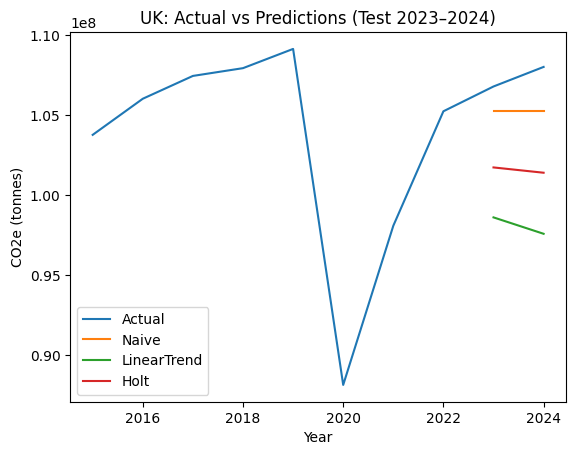

In [11]:
best_model = metrics_uk.iloc[0]["model"]
print("Best UK model:", best_model)

plt.figure()
plt.plot(uk["year"], uk["co2e_tonnes_total"], label="Actual")

plt.plot(test_uk["year"], pred_naive, label="Naive")
plt.plot(test_uk["year"], pred_lin, label="LinearTrend")
if "pred_holt" in globals():
    plt.plot(test_uk["year"], pred_holt, label="Holt")

plt.xlabel("Year")
plt.ylabel("CO2e (tonnes)")
plt.title("UK: Actual vs Predictions (Test 2023–2024)")
plt.legend()
plt.show()


In [12]:
metrics_uk.to_csv(os.path.join(OUT_DIR, "uk_model_metrics.csv"), index=False)


In [13]:
future_years = np.arange(latest+1, 2031)  # 2025-2030
future_df = pd.DataFrame({"year": future_years})


train_full = uk.copy()


best = metrics_uk.iloc[0]["model"]

if best == "Naive":
    future_pred = np.full(len(future_df), train_full["co2e_tonnes_total"].iloc[-1])
elif best == "LinearTrend":
    X = train_full[["year"]].values
    y = train_full["co2e_tonnes_total"].values
    m = LinearRegression().fit(X, y)
    future_pred = m.predict(future_df[["year"]].values)
elif best == "Holt":
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    y = train_full["co2e_tonnes_total"].values
    fit = ExponentialSmoothing(y, trend="add", seasonal=None).fit(optimized=True)
    future_pred = fit.forecast(len(future_df))
else:
    raise ValueError("Unknown best model")

uk_forecast = future_df.copy()
uk_forecast["co2e_tonnes_total_forecast"] = future_pred
uk_forecast.head()


,year,co2e_tonnes_total_forecast
0,2025,1.080126e+08
1,2026,1.080126e+08
2,2027,1.080126e+08
3,2028,1.080126e+08
4,2029,1.080126e+08


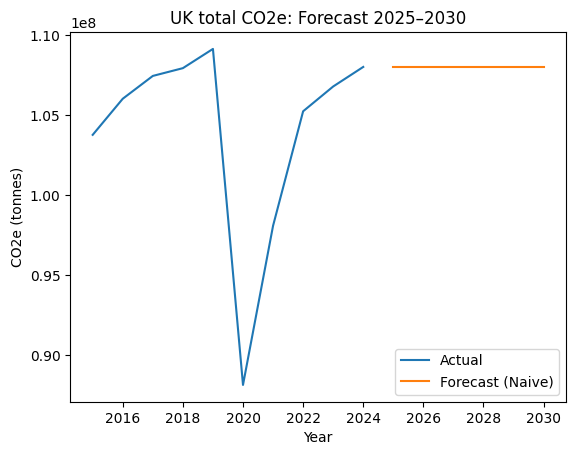

In [14]:
plt.figure()
plt.plot(uk["year"], uk["co2e_tonnes_total"], label="Actual")
plt.plot(uk_forecast["year"], uk_forecast["co2e_tonnes_total_forecast"], label=f"Forecast ({best})")
plt.xlabel("Year")
plt.ylabel("CO2e (tonnes)")
plt.title("UK total CO2e: Forecast 2025–2030")
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "uk_forecast_2025_2030.png"), dpi=300, bbox_inches="tight")
plt.show()

uk_forecast.to_csv(os.path.join(OUT_DIR, "uk_forecast_2025_2030.csv"), index=False)


In [15]:
for te in [2021, 2022]:
    tr, ts = train_test_split_ts(uk, train_end=te)
    pn = fit_predict_naive(tr, ts)
    pl = fit_predict_linear(tr, ts)
    print("train_end =", te,
          "| Naive RMSE:", rmse(ts["co2e_tonnes_total"], pn),
          "| Linear RMSE:", rmse(ts["co2e_tonnes_total"], pl))


train_end = 2021 | Naive RMSE: 8668269.015867863 | Linear RMSE: 13139198.016760416
train_end = 2022 | Naive RMSE: 2244995.732778798 | Linear RMSE: 9370494.42836207


In [16]:
from sklearn.linear_model import LinearRegression

future_years = np.arange(latest+1, 2031)  # 2025–2030

all_metrics = []
all_forecasts = []

for r in top5_regions:
    ts = (co2e[co2e["region_name"]==r]
          .sort_values("year")[["year","co2e_tonnes_total"]]
          .reset_index(drop=True))

    train, test = train_test_split_ts(ts, train_end=2022)

    # predictions on test
    p_naive = fit_predict_naive(train, test)
    p_lin   = fit_predict_linear(train, test)

    candidates = [("Naive", p_naive), ("LinearTrend", p_lin)]

    # Holt
    try:
        p_holt = fit_predict_holt(train, test)
        candidates.append(("Holt", p_holt))
    except:
        pass

    # metrics table
    for name, pred in candidates:
        all_metrics.append([r, name,
                            mae(test["co2e_tonnes_total"], pred),
                            rmse(test["co2e_tonnes_total"], pred),
                            mape(test["co2e_tonnes_total"], pred)])

    # choose best by RMSE
    tmp = pd.DataFrame(all_metrics, columns=["region_name","model","MAE","RMSE","MAPE(%)"])
    best_row = tmp[tmp["region_name"]==r].sort_values("RMSE").iloc[0]
    best_model_r = best_row["model"]

    # fit on full series + forecast future
    future_df = pd.DataFrame({"year": future_years})

    if best_model_r == "Naive":
        future_pred = np.full(len(future_df), ts["co2e_tonnes_total"].iloc[-1])
    elif best_model_r == "LinearTrend":
        m = LinearRegression().fit(ts[["year"]].values, ts["co2e_tonnes_total"].values)
        future_pred = m.predict(future_df[["year"]].values)
    elif best_model_r == "Holt":
        from statsmodels.tsa.holtwinters import ExponentialSmoothing
        fit = ExponentialSmoothing(ts["co2e_tonnes_total"].values, trend="add", seasonal=None).fit(optimized=True)
        future_pred = fit.forecast(len(future_df))
    else:
        raise ValueError("Unknown model")

    f = future_df.copy()
    f["region_name"] = r
    f["forecast_model"] = best_model_r
    f["co2e_tonnes_total_forecast"] = future_pred
    all_forecasts.append(f)

metrics_regions = pd.DataFrame(all_metrics, columns=["region_name","model","MAE","RMSE","MAPE(%)"])
metrics_regions = metrics_regions.sort_values(["region_name","RMSE"])

forecasts_regions = pd.concat(all_forecasts, ignore_index=True)

metrics_regions.head(15), forecasts_regions.head()


(        region_name        model           MAE          RMSE    MAPE(%)
 3   East of England        Naive  2.406664e+05  2.442091e+05   1.932630
 5   East of England         Holt  7.057428e+05  7.069545e+05   5.669492
 4   East of England  LinearTrend  1.010783e+06  1.014025e+06   8.119407
 6        North West        Naive  2.817270e+05  3.037664e+05   2.402975
 8        North West         Holt  8.483856e+05  8.603321e+05   7.252851
 7        North West  LinearTrend  1.029906e+06  1.043282e+06   8.805248
 0        South East        Naive  3.512019e+05  3.595980e+05   2.086465
 2        South East         Holt  1.252626e+06  1.261014e+06   7.445321
 1        South East  LinearTrend  1.803757e+06  1.816729e+06  10.720907
 9        South West        Naive  2.387963e+05  2.418724e+05   2.188740
 11       South West         Holt  6.700044e+05  6.728251e+05   6.142571
 10       South West  LinearTrend  8.635294e+05  8.680085e+05   7.916517
 12    West Midlands        Naive  2.415720e+05  2.

In [17]:
metrics_regions.to_csv(os.path.join(OUT_DIR, "top5_regions_model_metrics.csv"), index=False)
forecasts_regions.to_csv(os.path.join(OUT_DIR, "top5_regions_forecasts_2025_2030.csv"), index=False)
print("Saved region outputs to:", OUT_DIR)


Saved region outputs to: D:\UWE CLASS\CSCT master\Master_project\Outputs\Forecasting


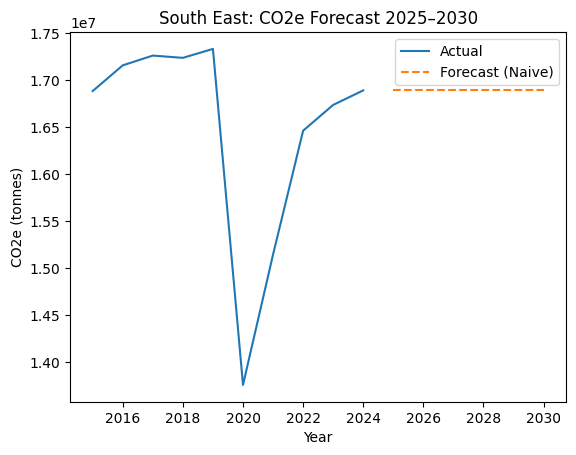

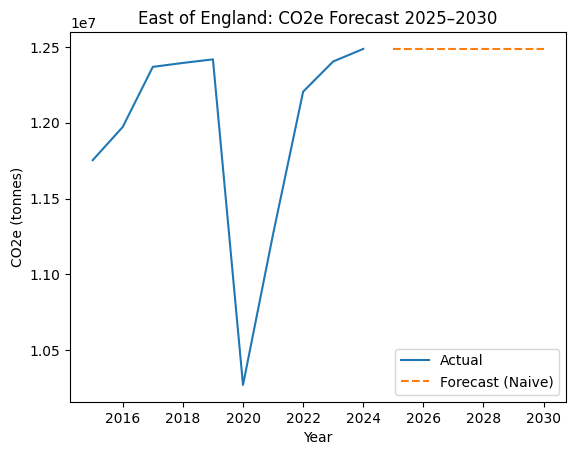

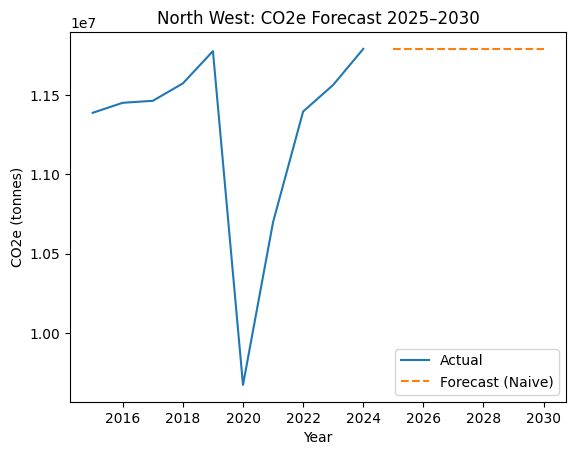

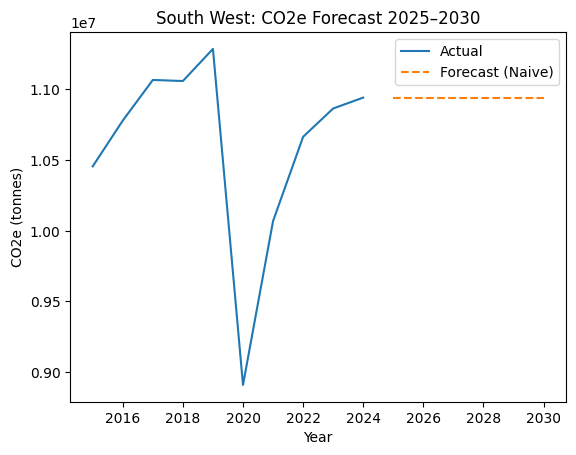

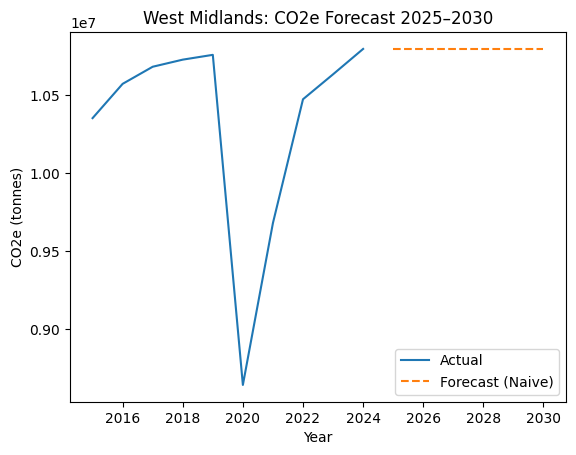

In [21]:
import os
import matplotlib.pyplot as plt

for r in top5_regions:
    hist = co2e[co2e["region_name"]==r].sort_values("year")
    fut  = forecasts_regions[forecasts_regions["region_name"]==r].sort_values("year")
    model_name = fut["forecast_model"].iloc[0]

    plt.figure()
    plt.plot(hist["year"], hist["co2e_tonnes_total"], label="Actual")
    plt.plot(fut["year"], fut["co2e_tonnes_total_forecast"], linestyle="--", label=f"Forecast ({model_name})")

    plt.xlabel("Year")
    plt.ylabel("CO2e (tonnes)")
    plt.title(f"{r}: CO2e Forecast 2025–2030")
    plt.legend()

    fname = f"forecast_{r.replace(' ','_')}_2025_2030.png"
    plt.savefig(os.path.join(OUT_DIR, fname), dpi=300, bbox_inches="tight")
    plt.show()
